In [113]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 16
region = "volcanopuyehue"
include_time = False
smooth = None

model_dir="/tmp/models/"
log_dir = "/tmp/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}_until{enddate}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_until{enddate}"

#model_path = os.path.join(model_dir,name_pattern.format(region=region, num_layers=num_layers, 
#                                                        hidden_size=hidden_size, epoch=epoch, enddate=enddate)) 

from dataset import transform_data
from copy import deepcopy
inner_steps = 0

enddate = '2015-01-01'
remove_seasonality=True

testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None),
                       remove_seasonality=remove_seasonality,
                       smooth=smooth)


#dataset = Sentinel5Dataset(fold="train", seq_length=300)
#validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

date = testdataset.date[0].astype(np.datetime64)

end_idx = np.where(np.isin(date.astype(str), np.array(enddate)))[0]
assert len(end_idx) > 0


def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

#def criterion(y_pred, y_data, log_variances):
#    norm = (y_pred-y_data)**2
#    return norm.mean()


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

local dataset found at /tmp/VolcanoPuyehue.csv
loading cached dataset found at /tmp/VolcanoPuyehue.npz
2181.465276299127 1775.767415250784


## Get Data Sample

In [122]:
idx = 1 # 17
x = testdataset.data[idx].astype(float)
x.mean()

0.7553297528364213

# Initialize model from Bavarian Dataset

In [27]:
!wget -nc "https://syncandshare.lrz.de/dl/fiGTU3DB2ZjgqNQkzvv4wqaX/LSTM_germany_l%3D1_h%3D128_e%3D2.pth" -P /tmp/

--2020-05-27 11:27:01--  https://syncandshare.lrz.de/dl/fiGTU3DB2ZjgqNQkzvv4wqaX/LSTM_germany_l%3D1_h%3D128_e%3D2.pth
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1594936 (1,5M) [application/octet-stream]
Saving to: ‘/tmp/LSTM_germany_l=1_h=128_e=2.pth’

LSTM_germany_l=1_h= 100%[===================>]   1,52M  --.-KB/s    in 0,1s    

2020-05-27 11:27:02 (10,7 MB/s) - ‘/tmp/LSTM_germany_l=1_h=128_e=2.pth’ saved [1594936/1594936]



In [140]:

model = Model(input_size=1 if not include_time else 2,
              hidden_size=128,
              num_layers=1,
              output_size=1,
              device=device,
              dropout=0.7)

#restore("/tmp/models/LSTM_volcanopuyehue_l=3_h=256_e=1_until2010-01-01.pth",model)
restore("/tmp/LSTM_germany_l=1_h=128_e=2.pth",model)


restoring model from /tmp/LSTM_germany_l=1_h=128_e=2.pth


## Predict from 2011 onwards

saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/before_event


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6a0895ba8>,
       dtype=object))

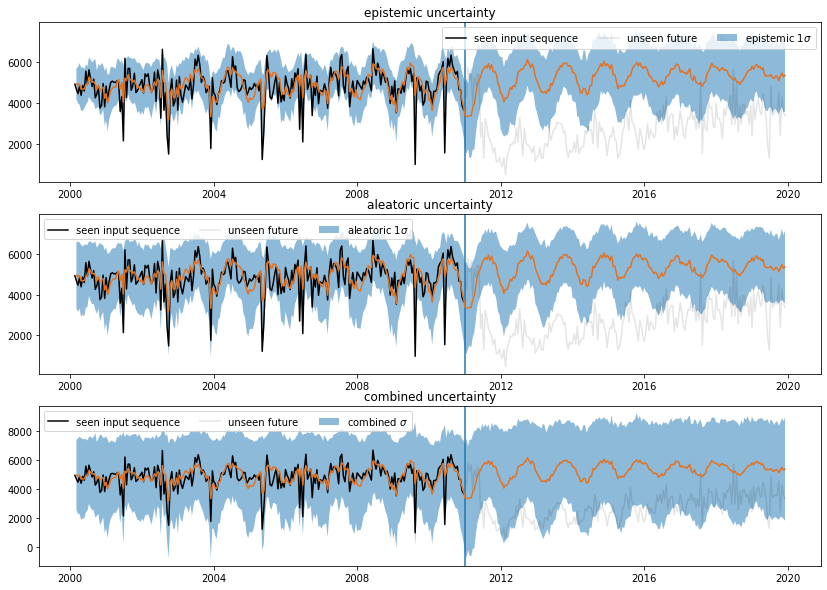

In [145]:
enddate = "2011-01-01"

end_idx = np.where(np.isin(date.astype(str), np.array(enddate)))[0]
N_seen_points = end_idx[0]#227
N_predictions = 100

x_train = x[:N_seen_points]
mean = x_train.mean(0)
std = x_train.std(0)
x_ = x - mean
#x_ = x_ / std

store = "/home/marc/projects/igarss2020_tex/img/puyehoevolcano/before_event" #/home/marc/projects/igarss2020_tex/img/puyehoevolcano_failure/puyehoevolcano"

make_and_plot_predictions(model, x_, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(float(mean * dataset.std + dataset.mean),float(dataset.std)), store=store)

# Predict from 2014 forward

saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/after_event


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6a0a2b6a0>,
       dtype=object))

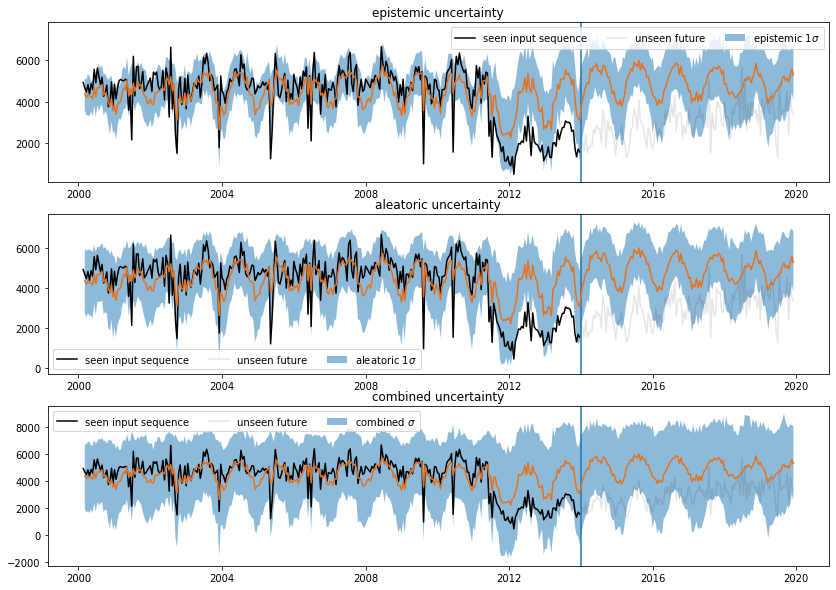

In [144]:
enddate = "2014-01-01"

end_idx = np.where(np.isin(date.astype(str), np.array(enddate)))[0]
N_seen_points = end_idx[0]#227
N_predictions = 50

x_train = x[:N_seen_points]
mean = x_train.mean(0)
std = x_train.std(0)
x_ = x - mean

store = "/home/marc/projects/igarss2020_tex/img/puyehoevolcano/after_event" #/home/marc/projects/igarss2020_tex/img/puyehoevolcano_failure/puyehoevolcano"

make_and_plot_predictions(model, x_, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(float(mean * dataset.std + dataset.mean),float(dataset.std)), store=store)